In [1]:
# Import libraries needed in the lab
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

seed = 42 # set a random seed for random operatioons to make results reproducible
np.random.seed(seed)

# Unsupervised Learning

_by Staffan Arvidsson McShane, updated by M. Andreina Francisco R and M.Sicho_

In this practical, we will look at three different unsupervised learning algorithms that are relatively simple to understand and implement, namely [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [Hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) and [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering). As data set we will use one of the small toy examples available in the scikit-learn library, the [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html). Note that this data is much, much simpler than typical data we encounter in drug discovery, as you will see first hand in the follow up assignments.

The [Iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html) is an old classification dataset used by sir R. A. Fisher in 1936. It includes 150 observations from each of three species of the *Iris* plant (*Setosa*, *Versicolor* and *Virginica). The features of each flower are sepal and petal lengths and widths (four features in total):

![iris-machinelearning](images/Flores_de_Íris.png)

<i><a href="https://commons.wikimedia.org/wiki/File:Flores_de_%C3%8Dris.png">Diego Mariano</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons</i>

## Loading the Data Set

We can better understand the data set after we load it so let us do just that now. Luckily, the machine learning package `scikit-learn` provides the data for us already:

In [2]:
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data # the descriptor variables (the features -> sepal/petal length and width)
y = iris.target # the label/target variable (normally unavailable in unsupervised machine learning)

print(f"Iris dataset contains {X.shape[0]} records, each with {X.shape[1]} features")
print(f"The irises are of {len(np.unique(y))} different classes: {iris.target_names}")

Iris dataset contains 150 records, each with 4 features
The irises are of 3 different classes: ['setosa' 'versicolor' 'virginica']


Typically, in unsupervised machine learning, we do not have the target values (i.e. classes, labels or response values) for the observations, but here it is convenient for assessing how well the showcased methods will actually work to help us understand the data. The algorithms themselves do not have access to any target values, **only** the features/descriptors! So try to imagine a hypothetical scenario in which you collected this data without knowing there are actually three species of the *Iris* plant. Go through the cells in this notebook one by one, try and understand what is going on, and think about the expected results and how they would actually help you to understand the data had you not known the labels, that is only with the consideration of the `X` matrix (even though we will also use the `y` on occasion to illustrate some ideas more clearly).

## Visualizing the Data

Before more complex visualizations, it is a good idea to verify our data and perhaps even annotate it with some metadata. The `pandas` package provides a lot of useful functionalities to work with tabular data as so called data frames. This code will convert the simple `X` matrix above to a data frame: 

In [3]:
df_X = pd.DataFrame(X, columns=iris.feature_names)
df_X

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


As you can see, this object also renders nicely in the Jupyter noteboo. And if you just want to get back your original matrix, you can always get it with the `values` attribute:

In [4]:
df_X.values[0:10] # only first ten items for clarity

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1]])

We can also do the same thing for the `y` array and have a more descriptive label for the classes:

In [5]:
df_y = pd.DataFrame([iris.target_names[idx] for idx in y], columns=["Label"])
df_y

,Label
0,setosa
1,setosa
2,setosa
3,setosa
4,setosa
...,...
145,virginica
146,virginica
147,virginica
148,virginica


### Scatter Plots

First we will have a look at the data with the most simple method, which is by creating a scatter plot for every pair of features. Looking at the plots, can you cluster the examples by hand? How many clusters do you see?

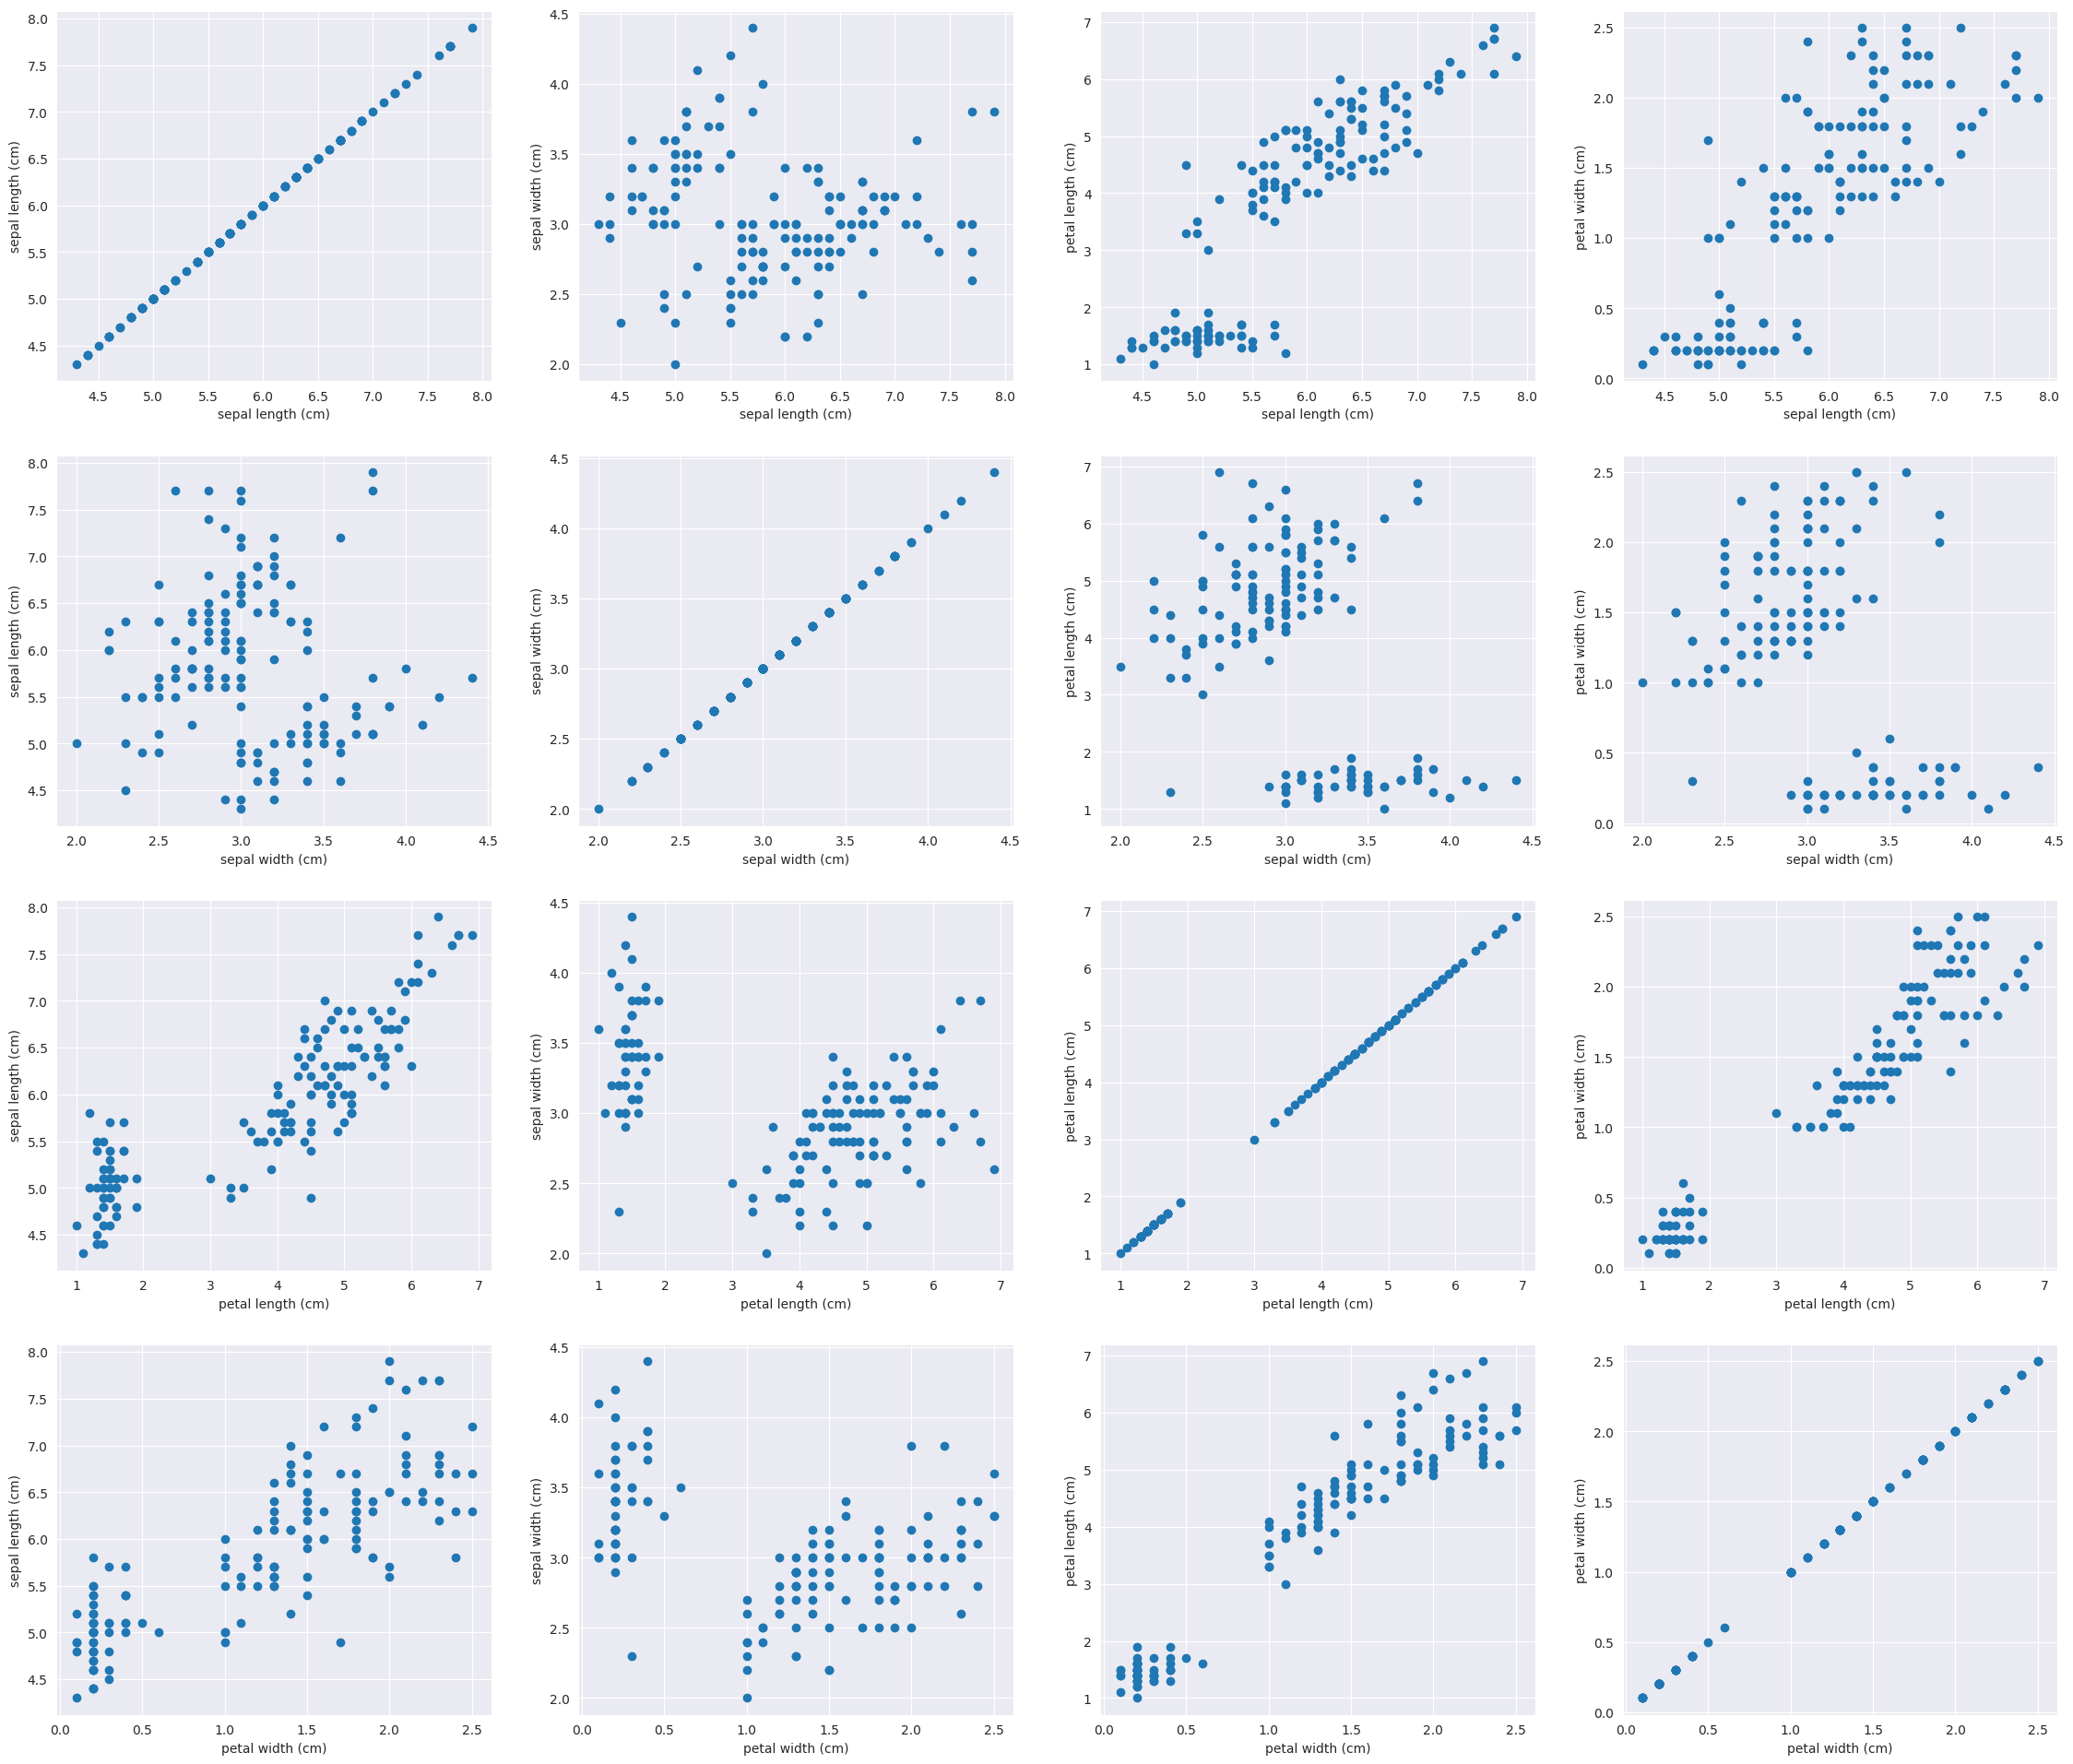

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(7*4, 6*4))

for i in range(0,4):
    for j in range(0,4):
        axes[i,j].scatter(X[:, i], X[:, j])
        axes[i,j].set_xlabel(df_X.columns[i])
        axes[i,j].set_ylabel(df_X.columns[j])

These plots can already give us a hint on the number of expected classes in our data set and what features contribute the most to their separation. For example, we can see that petal length together with petal width give good separation, but sepal length and sepal width not so much.  But also notice that if we were to look at the plots without knowing the labels, we would probably assume there are only two distinct groups in the data. This is because the *Setosa* species is very distinct from the other two species, and the other two species are quite similar to each other. This is a typical problem in unsupervised machine learning, where the data is not very well separated by pairs of features alone and the number of clusters is not obvious. In addition, the groups we are seeing in each scatter plot might not always be the same two groups like in the others (each pair of features can define a completely different clustering of the data). This is where the more advanced methods come in, but we will get to that later.

 You can check the solution by replacing the line:

`axes[i,j].scatter(X[:, i], X[:, j])`

with:

`axes[i,j].scatter(X[:, i], X[:, j], c=y)`

which will color the examples after their classes. Not so simple, right? Perhaps a separation is not possible using only two features.

#### Note on Plotting with Pandas

You can also draw these plots easily with pandas alone with its built-in functionality:

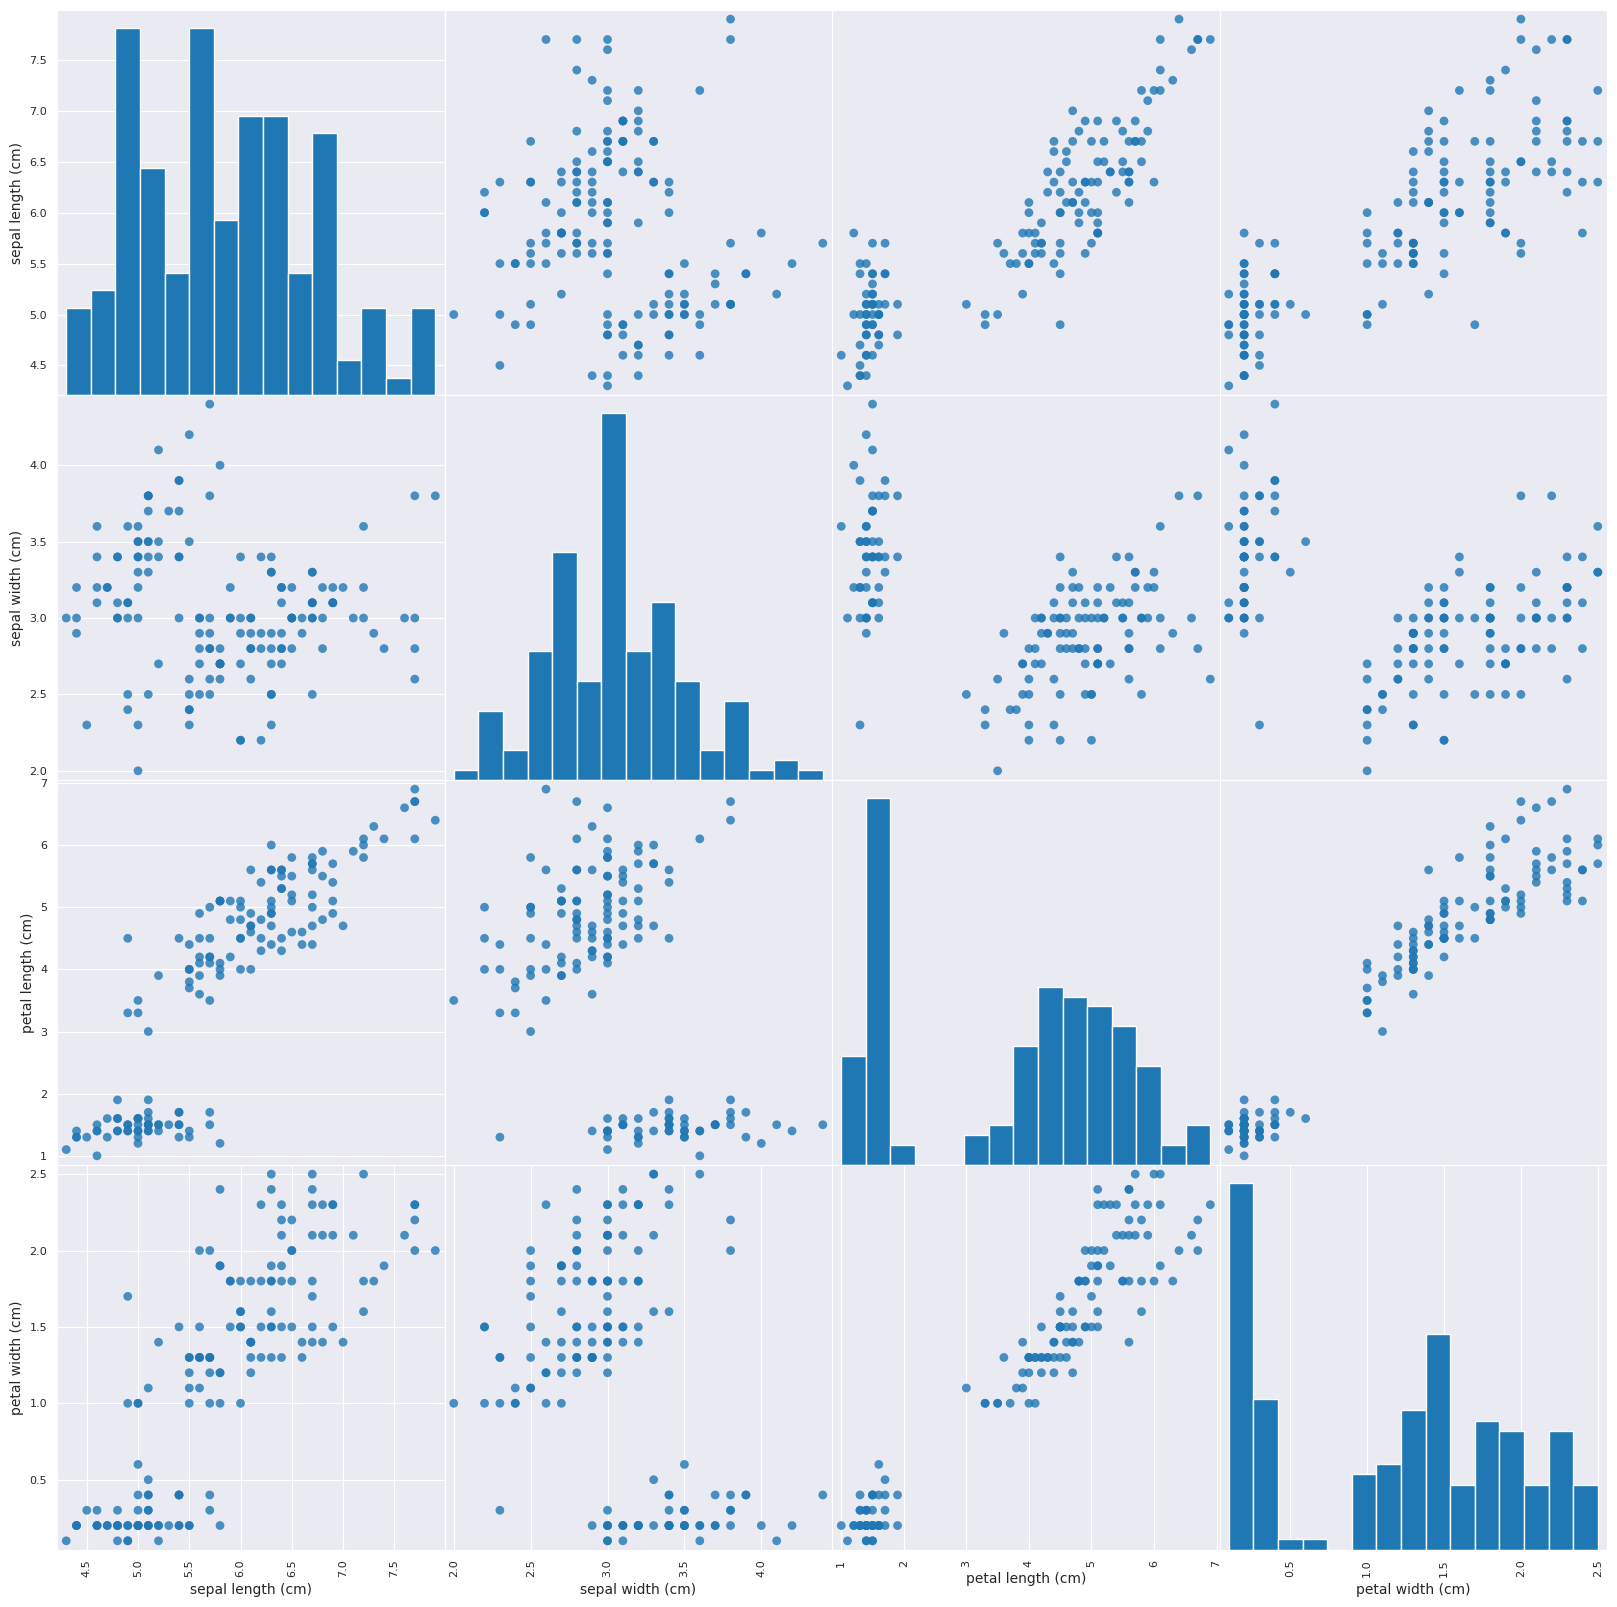

In [7]:
from pandas.plotting import scatter_matrix

scatter_matrix_settings = {
    # try to play with these settings to see how they affect the plots
    'figsize': (20,20),
    'marker': 'o',
    'hist_kwds': {'bins':15},
    's' : 40,
    'alpha' : .8
}

axes = scatter_matrix(df_X, **scatter_matrix_settings) # histograms of each feature alone are on the diagonal

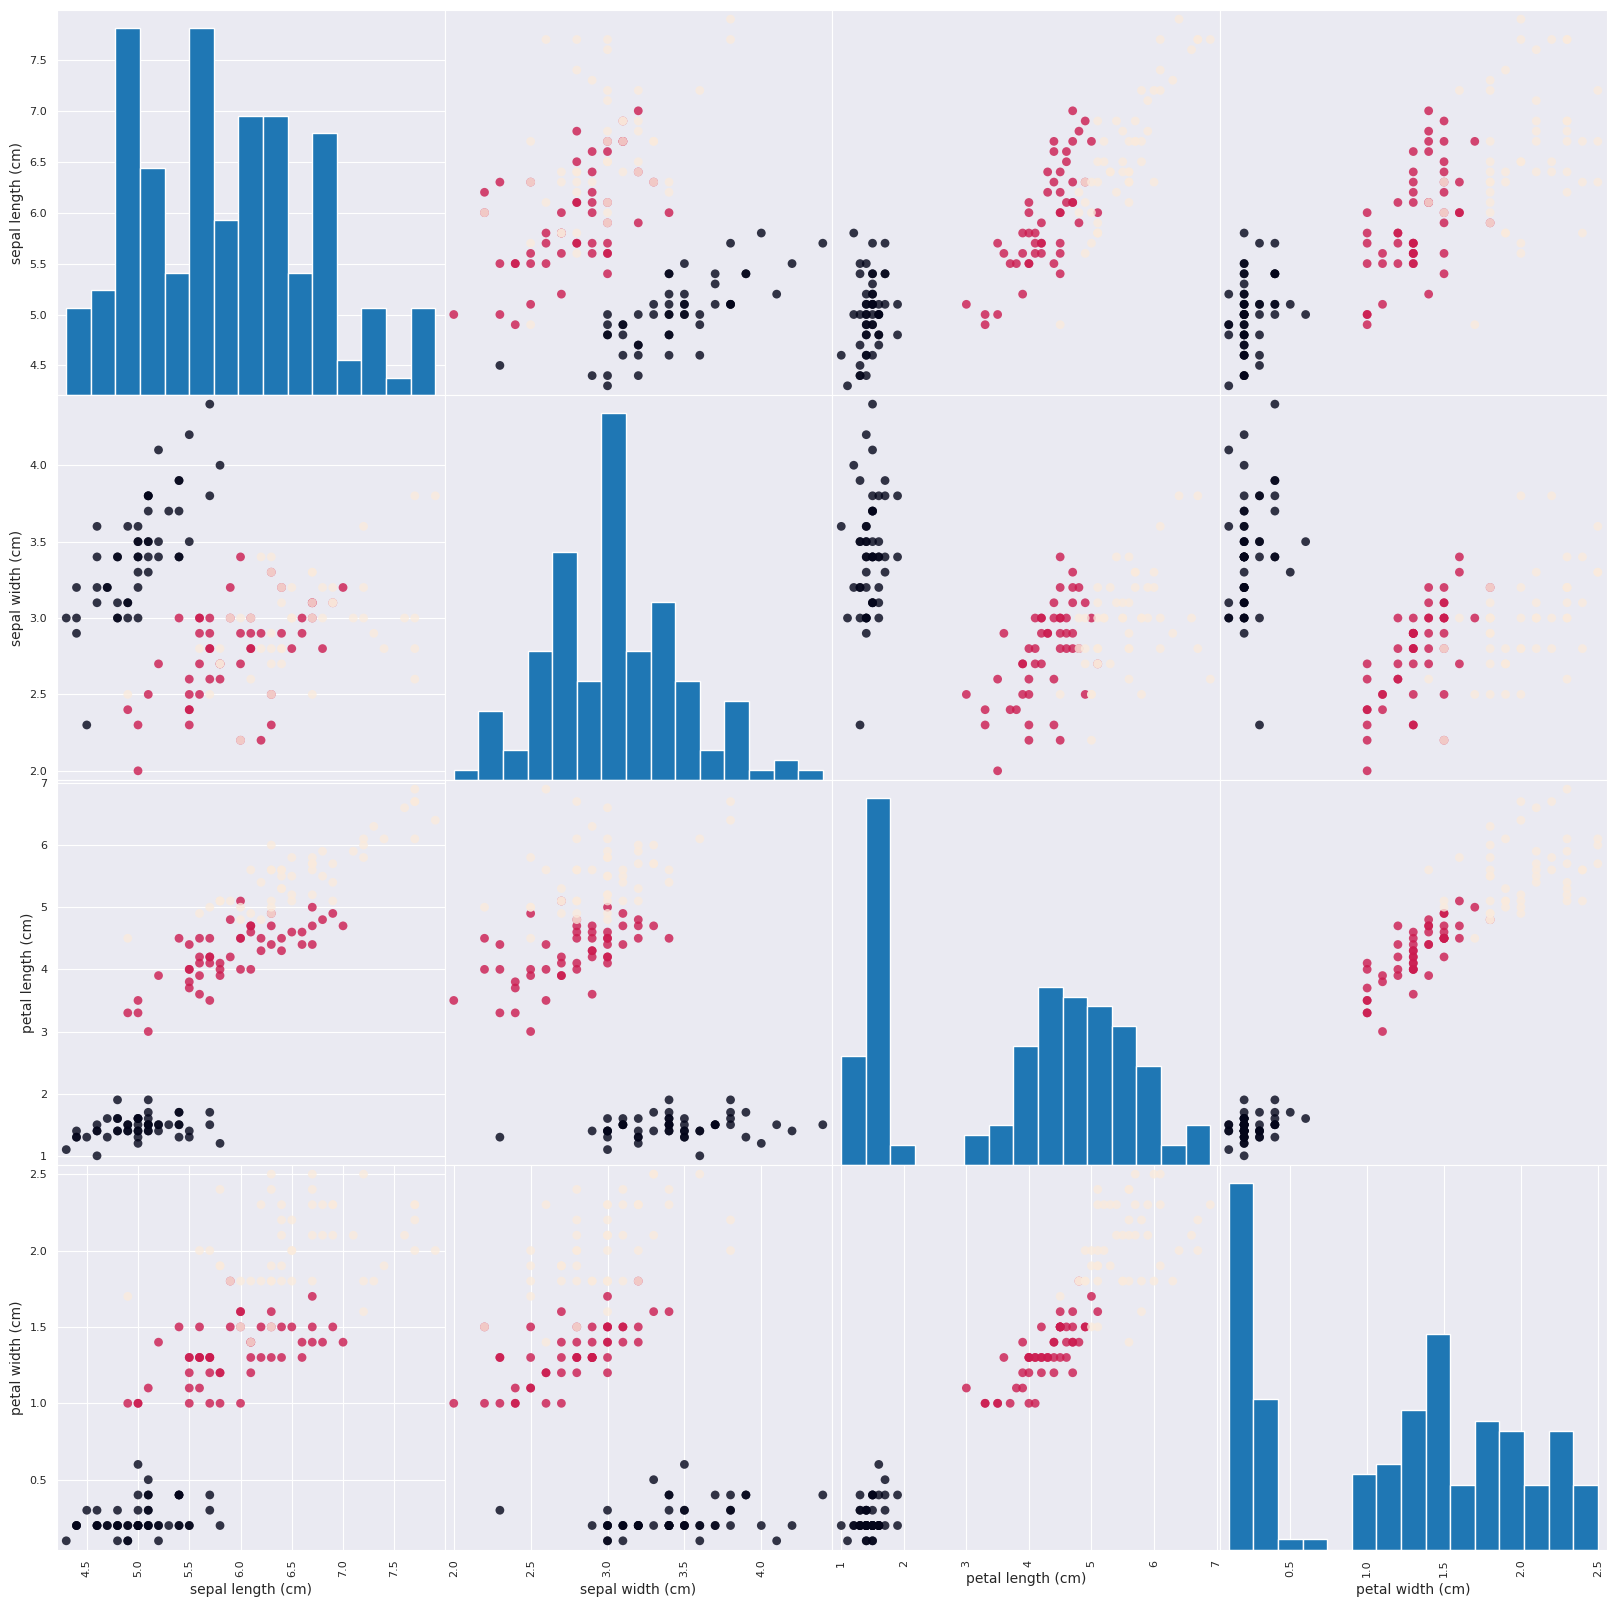

In [8]:
axes = scatter_matrix(df_X, c=y, **scatter_matrix_settings) # colored by class label

### Principal Component Analysis (PCA)

The first dimensionality reduction method we will try is the [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), which is based on simple matrix decomposition. Unlike the other dimensionality reduction methods below, this makes PCA much more interpretable and also deterministic, which means we will always get the same embedding every time. Here we will try to decompose the four available features into a tighter representation in fewer dimensions. First we can run PCA, specifying that we wish to have four output dimensions and plot the explained variance in each of the new dimensions:

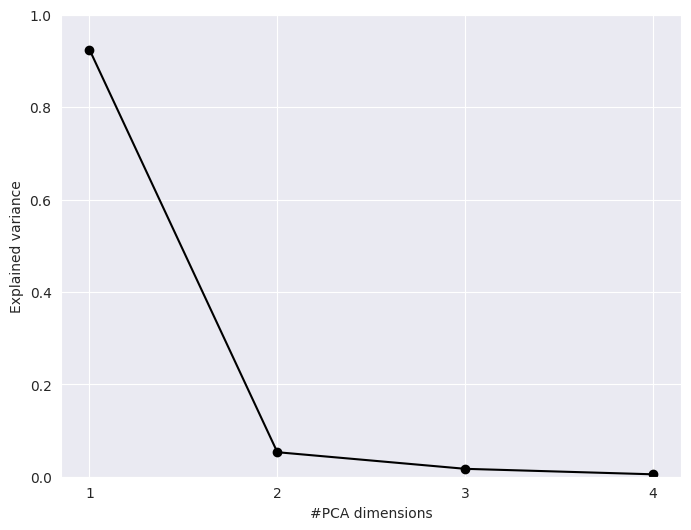

Total sum: 1.0
Each dimension contributes with: [0.92461872 0.05306648 0.01710261 0.00521218]


In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_transformed = pca.fit_transform(df_X)

plt.figure(figsize=(8, 6))
plt.plot(list(range(1,5)),pca.explained_variance_ratio_,'ok-')
plt.xlabel("#PCA dimensions")
plt.xticks(list(range(1,5)))
plt.ylabel("Explained variance")
plt.ylim((0,1))
plt.show()

print("Total sum: {0}\nEach dimension contributes with: {1}".format(sum(pca.explained_variance_ratio_),pca.explained_variance_ratio_))

Clearly, most of the variance can be described using only a single dimension, given the assumptions of PCA. So let us look at what it will do for us to only use the first principal component. Can we now distinguish the classes after this transformation? We will label the points by class again, but remember that in real life these labels are unknown.

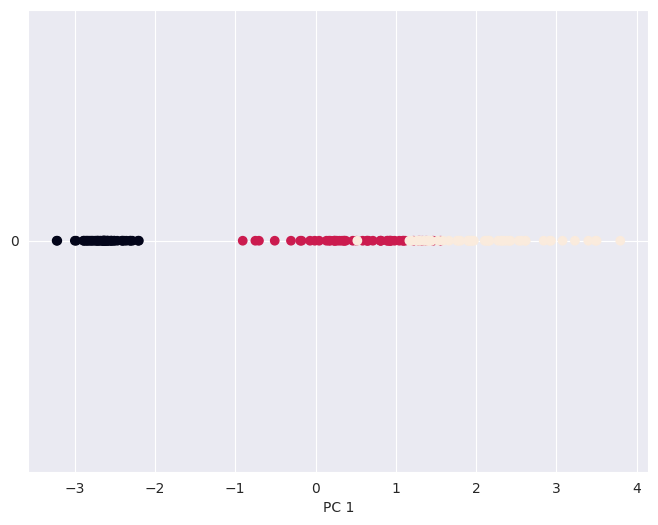

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(X_transformed[:,0],[0] * len(X_transformed),c=y)
plt.xlabel('PC 1')
plt.yticks((0,))
plt.show()

It seems that we can separate one of the classes again, but with the other two, things are a bit blurry again. Therefore, let us consider data in 2D instead and add the second principal component as well:

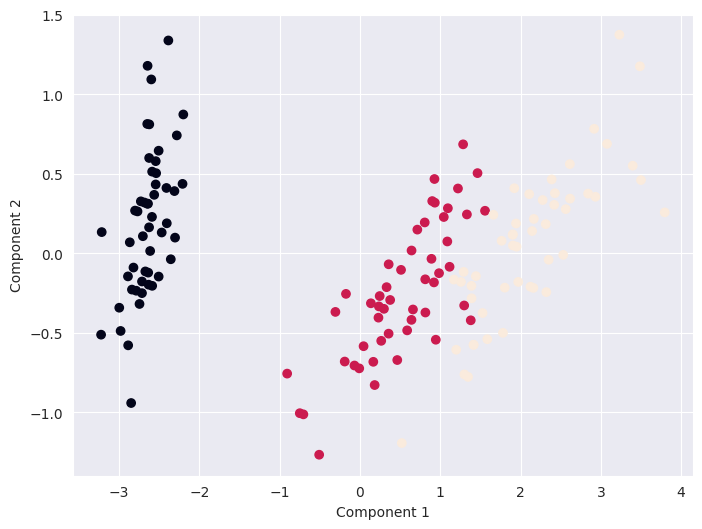

In [11]:
plt.figure(figsize=(8, 6))
plt.scatter(X_transformed[:,0],X_transformed[:,1], c=y)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

We can see that in 2D space, we would probably get a slightly better separation. It is much more clear now where we would need to draw the imaginary lines in this space between the three groups, but we still might be tempted to think there are only two, if we only look at the unlabeled data:

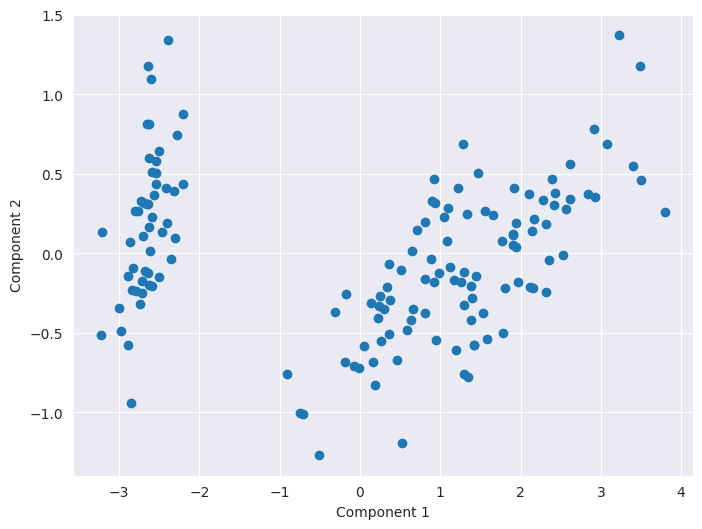

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(X_transformed[:,0],X_transformed[:,1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

#### PCA - Concluding remarks

PCA can be used for decomposing multidimensional data into a lower dimensional space, and here it could be used for visualising the data in 2D instead of having to manually look through 6 different plots to find features that could be useful for separating data into clusters. For a data set with $n$ features, this would be $\binom{n}{2}$ plots so you can see it will quickly get out of hand. As you will see in the assignment, cheminformatics data sets can become much larger and manual inspection is not feasible. Another thing to keep in mind is that PCA only aims at describing the variance in the data in the most compact way, which does not necessarily correspond to information that discriminates well between (potential) classes in the data. It is also a linear method and if there are nonlinear relationships in the data, the resulting principal components might not accurately capture the nature of such data, but there are [other methods](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction) that could help you there. It is also important to note that the way we plot our data can often affect and bias us in different ways. So it is often a good idea to use multiple techniques to spot different patterns in the data and to try to understand the data from different perspectives. Even in this simple example, things were not so simple, and we would most likely miss that *Versicolor* and *Virginica* are actually two different plants. The conclusions we can draw from data are only as good as the data itself and the way we choose to interpret it.

#### Note on Advanced Plotting

Besides `matplotlib` and built-in functions in `pandas`, there are other libraries with a more convenient API and richer plotting functionalities. Therefore, feel free to explore those as well. One popular library is [`seaborn`](https://seaborn.pydata.org/examples/index.html), which we will briefly showcase here as well by reproducing the ver first figure we created. Seaborn makes heavy use of `pandas` so we will concatenate the two data frames we created above:

In [13]:
df = pd.concat([df_X, df_y], axis=1)
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),Label
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


We can then have a much nicer plot with just a few lines of code:

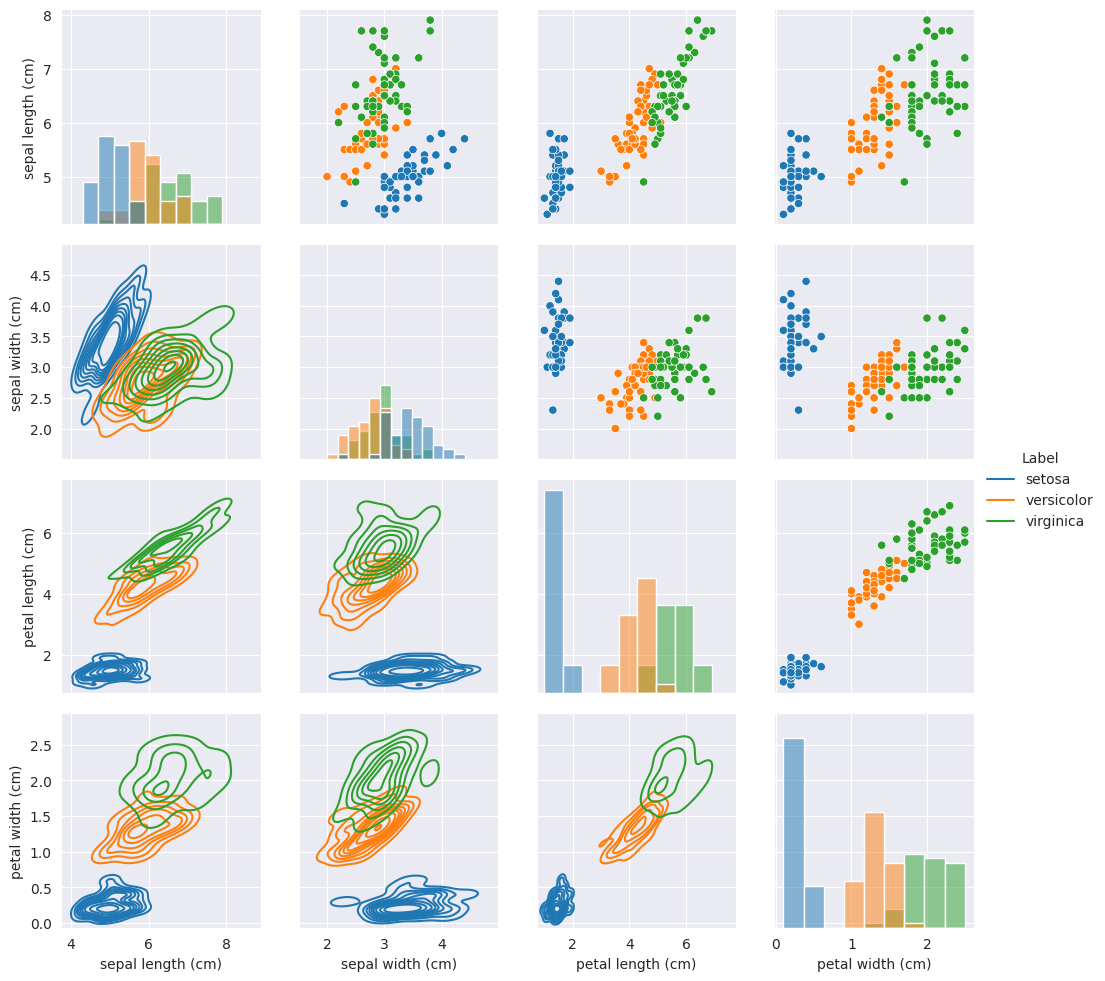

In [14]:
import seaborn as sns

g = sns.PairGrid(df, hue="Label")
g.map_diag(sns.histplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

The used KDE ([Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)) plots above can also be easily shown for our transformed PCA data:

In [15]:
df_transformed = pd.DataFrame(X_transformed[:,0:2], columns=["PC 1", "PC 2"])
df_transformed["Label"] = df.Label
df_transformed

,PC 1,PC 2,Label
0,-2.684126,0.319397,setosa
1,-2.714142,-0.177001,setosa
2,-2.888991,-0.144949,setosa
3,-2.745343,-0.318299,setosa
4,-2.728717,0.326755,setosa
...,...,...,...
145,1.944110,0.187532,virginica
146,1.527167,-0.375317,virginica
147,1.764346,0.078859,virginica
148,1.900942,0.116628,virginica


<Axes: xlabel='PC 1', ylabel='PC 2'>

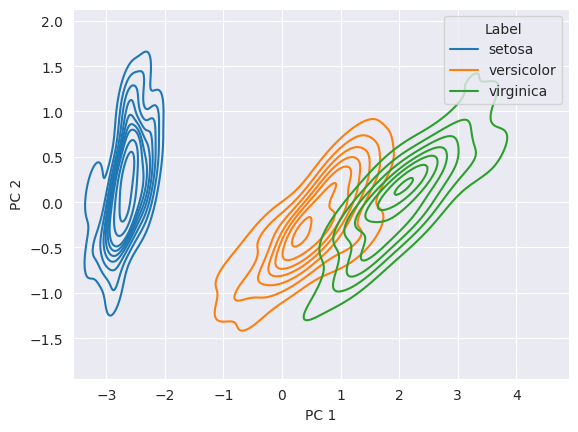

In [16]:
sns.kdeplot(data=df_transformed, x="PC 1", y="PC 2", hue="Label")

However, without the labels we would perhaps be even more tempted to only see two clusters in this depiction since the fitted distributions smoothed the data out quite a bit:

<Axes: xlabel='PC 1', ylabel='PC 2'>

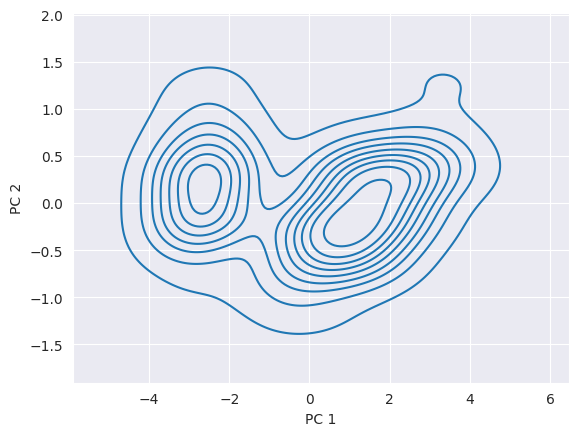

In [17]:
sns.kdeplot(data=df_transformed, x="PC 1", y="PC 2")

### UMAP

Another popular dimensionality reduction technique is [UMAP](https://umap-learn.readthedocs.io/en/latest/), which is a non-linear method that can be used to visualize high-dimensional data. It is mathematically more involved, but thanks to the `umap-learn` package, it is very easy to use. It also uses a similar interface as `scikit-learn` models so the code below should look familiar already:

In [18]:
import umap

umap_model = umap.UMAP(n_components=2, n_neighbors=50, min_dist=1.0, metric='euclidean', random_state=seed)
X_transformed = umap_model.fit_transform(X)
X_transformed

array([[ 1.4421358 , 11.227068  ],
       [-0.705867  ,  7.760505  ],
       [-1.1014664 ,  9.642225  ],
       [-0.54564387,  9.347247  ],
       [ 1.4223564 , 10.91998   ],
       [ 3.9893057 , 10.374311  ],
       [-0.32116115, 10.044698  ],
       [ 0.5549126 , 10.693314  ],
       [-1.9557618 ,  9.427666  ],
       [ 0.09886927,  8.056497  ],
       [ 2.8664017 , 11.093195  ],
       [ 0.2149635 ,  9.833355  ],
       [-1.063416  ,  8.828996  ],
       [-1.3114115 , 10.575287  ],
       [ 3.608509  , 11.740788  ],
       [ 3.3375466 , 10.55135   ],
       [ 3.8838127 , 11.309179  ],
       [ 1.3434697 , 10.944182  ],
       [ 3.2820463 , 11.299992  ],
       [ 2.8625228 ,  9.919983  ],
       [ 2.0519965 , 12.03778   ],
       [ 2.5581057 , 10.554554  ],
       [-0.3501831 , 10.597219  ],
       [ 1.605397  ,  9.331814  ],
       [ 1.1102343 ,  9.137132  ],
       [ 0.43069082,  8.343305  ],
       [ 1.6123244 , 10.3037615 ],
       [ 1.7079983 , 11.590098  ],
       [ 1.2734765 ,

Now, let's transform the data again so that we can make a nice depiction:

In [19]:
df_transformed = pd.DataFrame(X_transformed, columns=["UMAP 1", "UMAP 2"])
df_transformed["Label"] = df.Label
df_transformed

,UMAP 1,UMAP 2,Label
0,1.442136,11.227068,setosa
1,-0.705867,7.760505,setosa
2,-1.101466,9.642225,setosa
3,-0.545644,9.347247,setosa
4,1.422356,10.919980,setosa
...,...,...,...
145,14.899281,1.733424,virginica
146,16.109758,3.486558,virginica
147,16.121925,2.549088,virginica
148,14.121899,2.648754,virginica


<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

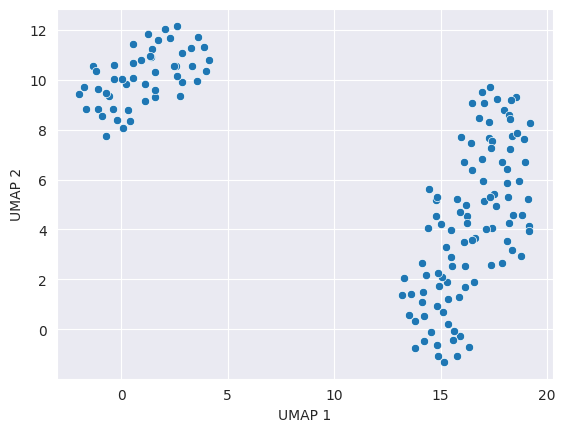

In [20]:
sns.scatterplot(data=df_transformed, x="UMAP 1", y="UMAP 2")

<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

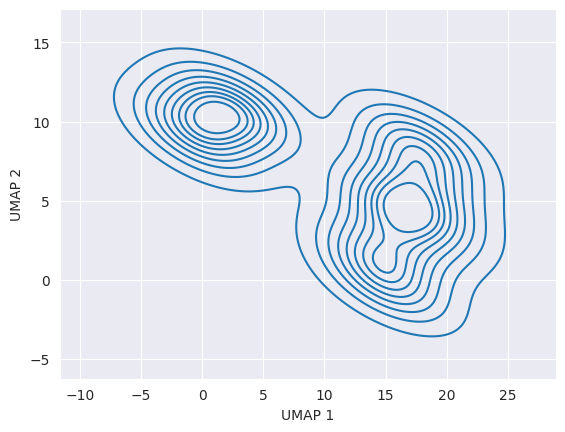

In [21]:
sns.kdeplot(data=df_transformed, x="UMAP 1", y="UMAP 2")

Once again, everything suggests two clusters, but we know that there are three. Try to vary the parameters of the `UMAP` class above and see how they affect the results in relation to the separation of the three classes (use the `hue` parameter to help you). Read the [documentation](https://umap-learn.readthedocs.io/en/latest/) for more information if needed.

### t-SNE

Another frequently used method for dimensionality reduction is [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), which is also a non-linear method. Unlike UMAP, t-SNE is focused more on local relationships and as such can generally cluster similar samples together, but the between cluster distances usually make little sense. Using t-SNE makes it also much harder to add new data points to the embedding without refitting it again, which can also make it quite cumbersome to use with large data sets. However, it is widely used in cheminformatics thanks to its ability cluster very similar compounds together. But let us see how it performs on our Iris data set:

In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=50, n_components=2, init='pca', random_state=seed)
X_transformed = tsne.fit_transform(X)
X_transformed

array([[-12.716257  ,   1.0229006 ],
       [-11.965117  ,   0.71562177],
       [-12.005564  ,   1.3069202 ],
       [-11.863273  ,   1.3086916 ],
       [-12.713225  ,   1.4388132 ],
       [-13.376094  ,   1.1919699 ],
       [-12.157208  ,   1.5609899 ],
       [-12.511527  ,   1.1984787 ],
       [-11.5518465 ,   1.1213229 ],
       [-12.061638  ,   0.7861256 ],
       [-13.192009  ,   0.84519154],
       [-12.354092  ,   1.5041597 ],
       [-11.864549  ,   0.8179918 ],
       [-11.493383  ,   1.2270795 ],
       [-13.635342  ,   0.807293  ],
       [-13.783066  ,   1.1534015 ],
       [-13.361922  ,   0.97188145],
       [-12.728014  ,   0.95426893],
       [-13.491065  ,   0.8111668 ],
       [-13.022298  ,   1.4158641 ],
       [-12.948396  ,   0.53605115],
       [-12.950067  ,   1.3739991 ],
       [-12.151045  ,   0.39201415],
       [-12.55642   ,   0.5152857 ],
       [-12.392125  ,   1.6880965 ],
       [-12.07531   ,   0.60637164],
       [-12.552376  ,   1.3386947 ],
 

In [23]:
df_transformed = pd.DataFrame(X_transformed, columns=["t-SNE 1", "t-SNE 2"])
df_transformed["Label"] = df.Label
df_transformed

,t-SNE 1,t-SNE 2,Label
0,-12.716257,1.022901,setosa
1,-11.965117,0.715622,setosa
2,-12.005564,1.306920,setosa
3,-11.863273,1.308692,setosa
4,-12.713225,1.438813,setosa
...,...,...,...
145,7.177941,-0.463731,virginica
146,5.803360,-1.122746,virginica
147,6.688363,-0.688369,virginica
148,7.199845,-0.334302,virginica


<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

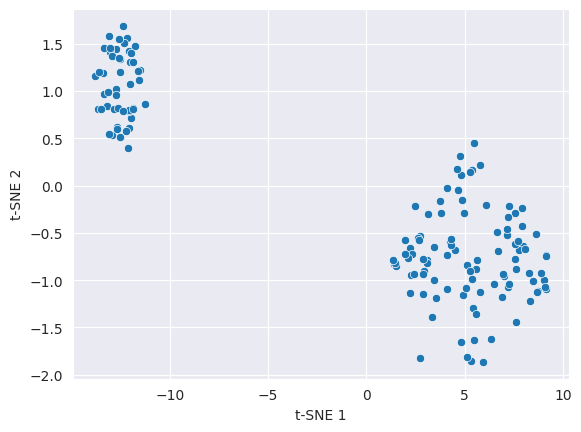

In [24]:
sns.scatterplot(data=df_transformed, x="t-SNE 1", y="t-SNE 2")

<Axes: xlabel='t-SNE 1', ylabel='t-SNE 2'>

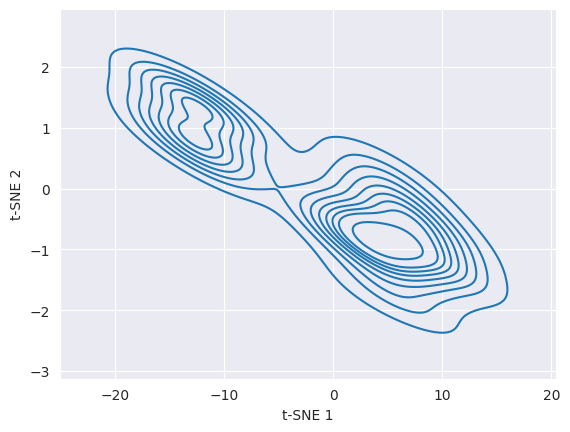

In [25]:
sns.kdeplot(data=df_transformed, x="t-SNE 1", y="t-SNE 2")

Again, even with this method it is hard to see three clusters. Try to vary the parameters of the `TSNE` class above and see how they affect the results in relation to the separation of the three classes (use the `hue` parameter to help you). Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) for more information if needed. What happens if you set `perplexity` to a really low value? What about a really high value?

## Hierarchical Clustering

PCA is a great method for visualization and you can see above that it can also give us an idea of what clusters we may expect in the data, but it does not give us the clusters directly. Therefore, we can use other unsupervised methods to do the actual clustering. In this section we will attempt to cluster the data using Hierarchical clustering implemented in [SciPy](https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html), which uses **Agglomerative clustering**. Remember that there are multiple ways to compute inter-cluster distance between clusters. These are the standard ones (see more [here](https://www.geeksforgeeks.org/ml-intercluster-and-intracluster-distance/)):

 1. **Single Linkage Distance** - the observations that are the closest together, 
 1. **Complete Linkage Distance** - the furthest away or
 1. **Average Linkage Distance** - the average distance between all observations in each cluster.

Therefore, in this exercise we will try to cluster our data using these three different methods and check if it makes any difference for our data. We will also try a few different distance metrics to illustrate that they can also significantly affect the clustering results. We still work with the *Iris* dataset and below we provide a simple function to compare different approaches. The cell below creates a grid of plots with different *distance metrics* and *linkage methods*, you will not have to change this cell. The cell after the definition `h_cluster` function with lists that you can alter yourselves. Again, try to read and understand this code:

In [26]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Code that creates a grid with different cluster metrics for each row,
# and different inter-cluster-distance methods for each column in the resulting plot
# You don't need to make any changes in this cell
label_c = {label : color  for label, color in zip(df_y.Label.unique(), ['g', 'r', 'b'])}

def h_cluster(X, y, methods, metrics):
    n_row = len(metrics)
    n_col = len(methods)
    fig, axes = plt.subplots(n_row, n_col, figsize=(8*n_col, 6*n_row))
    for r, metr in enumerate(metrics):
        for c, meth in enumerate(methods):
            ax = axes.flat[r*n_col + c]
            # The default metric is euclidean - make sure it's printed properly in the plot-title
            if metr is None:
                metr = 'euclidean'
            print("{0} : {1}, {2} : {3}".format(r,metr, c, meth))
            Z = linkage(X, method=meth, metric=metr)
            dendrogram(Z, ax=ax, labels=y) # ax=axes[i,j],
            ax.set_title("{0} linkage, {1} metric".format(meth, metr))
            ax.set_ylabel('Distance')
            ax.set_xlabel('Label')
    
    # Color all observations according to their labels
    for ax in axes.flat:
        xlbls = ax.get_xmajorticklabels()
        for lbl in xlbls:
            lbl.set_color(label_c[lbl.get_text()])
    fig

0 : euclidean, 0 : single
0 : euclidean, 1 : complete
0 : euclidean, 2 : average


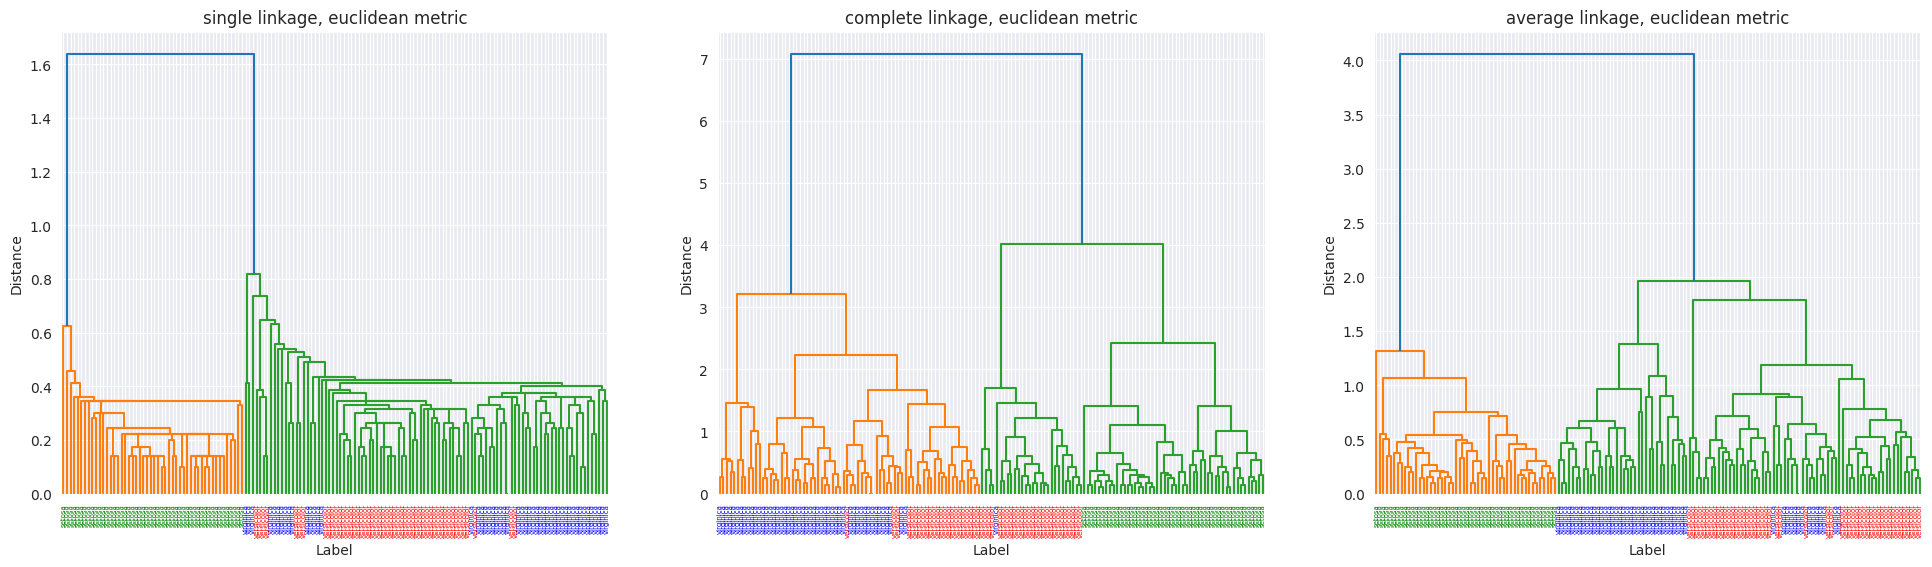

In [27]:
# Make changes to the arrays below to perform different clusterings
metrics = ['euclidean']
methods = ['single', 'complete', 'average']
h_cluster(df_X, df_y.Label.to_numpy(), methods, metrics)

The colors underneath the x-axis reflect the true labels so that we can track how each clustering method was able to separate the different *Iris* species. The color of the dendrogram branches in the trees are determined by the `dendrogram` function - a mismatch between these colors is not an indication of an error as the `dendrogram` function will assign labels/colors randomly. What is of interest is how the examples of the different classes are separated by the clustering algorithm, which is an indication of how well the algorithm works for this particular dataset.

**Task: try out a few different *distance metrics* and *linkage methods* to see how the clusters change. Do things behave like you expect them to?**

More distance metrics can be found in the [SciPy pdist](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) package. Note that this might take some time to compute and render, more methods/metrics will take longer time.

By default, the code will only color clusters differently if they are further apart than 70% of the maximum distance. You can alter this by setting the `color_threshold` parameter of the `dendrogram` function. Setting for example `color_threshold=1.8` seems to split the *Average linkage* with euclidean distance well and make it simpler to assess the results. You can alter the cell underneath for trying out a single method and metric at a time or write your own code in a new cell.

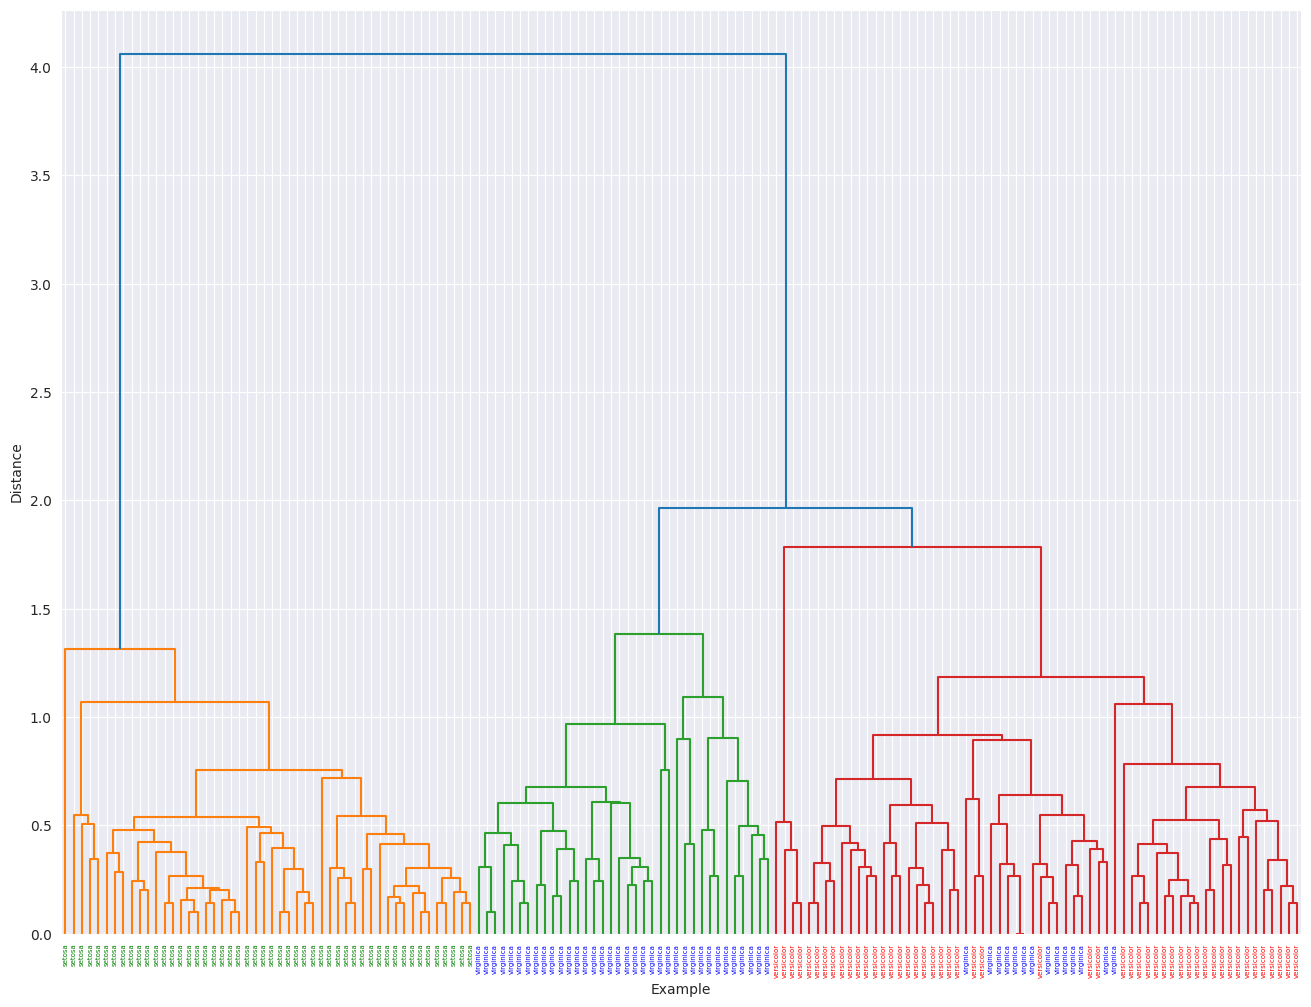

In [28]:
# Average linkage
fig= plt.figure(figsize=(16,12))
Z = linkage(df_X, method='average', metric='euclidean')
dendrogram(Z, color_threshold=1.8, labels=df_y.Label.to_numpy())
plt.ylabel('Distance')
plt.xlabel('Example')

xlbls = plt.gca().get_xmajorticklabels()
for lbl in xlbls:
    lbl.set_color(label_c[lbl.get_text()])

### Hierarchical Clustering - Concluding Remarks

Hierarchical clustering generates dendrograms that can be used to visualize the distances between data points in a higher dimension. The choice of *linkage method* and *distance metric* can have a large impact on the results and it is useful to try out different methods/metrics to see how things change. If you have knowledge of the feature space you can use it to make a better choice of method/metric. 

## K-means clustering

Here you will try another popular clustering method. *K*-means clustering is different from hierarchical clustering because it explicitly requires the number *K*, which is the number of clusters we expect to find in the data. This is usually a disadvantage, but can also be useful when we have some prior knowledge of the data. We will use the version implemented in the scikit-learn function [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).

In [29]:
from sklearn.cluster import KMeans

# Performs clustering and plots the result
def plot_clusters(K, feat_X = X, n_init = 1, seed = 42):
    fig, axes = plt.subplots(1,len(K),figsize=(8*len(K), 6))
    for i, k in enumerate(K):
        cluster_predictions = KMeans(n_clusters=k, n_init=n_init, random_state = seed).fit_predict(feat_X)
        ax = axes[i]
        ax.scatter(feat_X[:,0],feat_X[:,1],c=cluster_predictions)
        ax.set_title("K-means, K={0}".format(k))

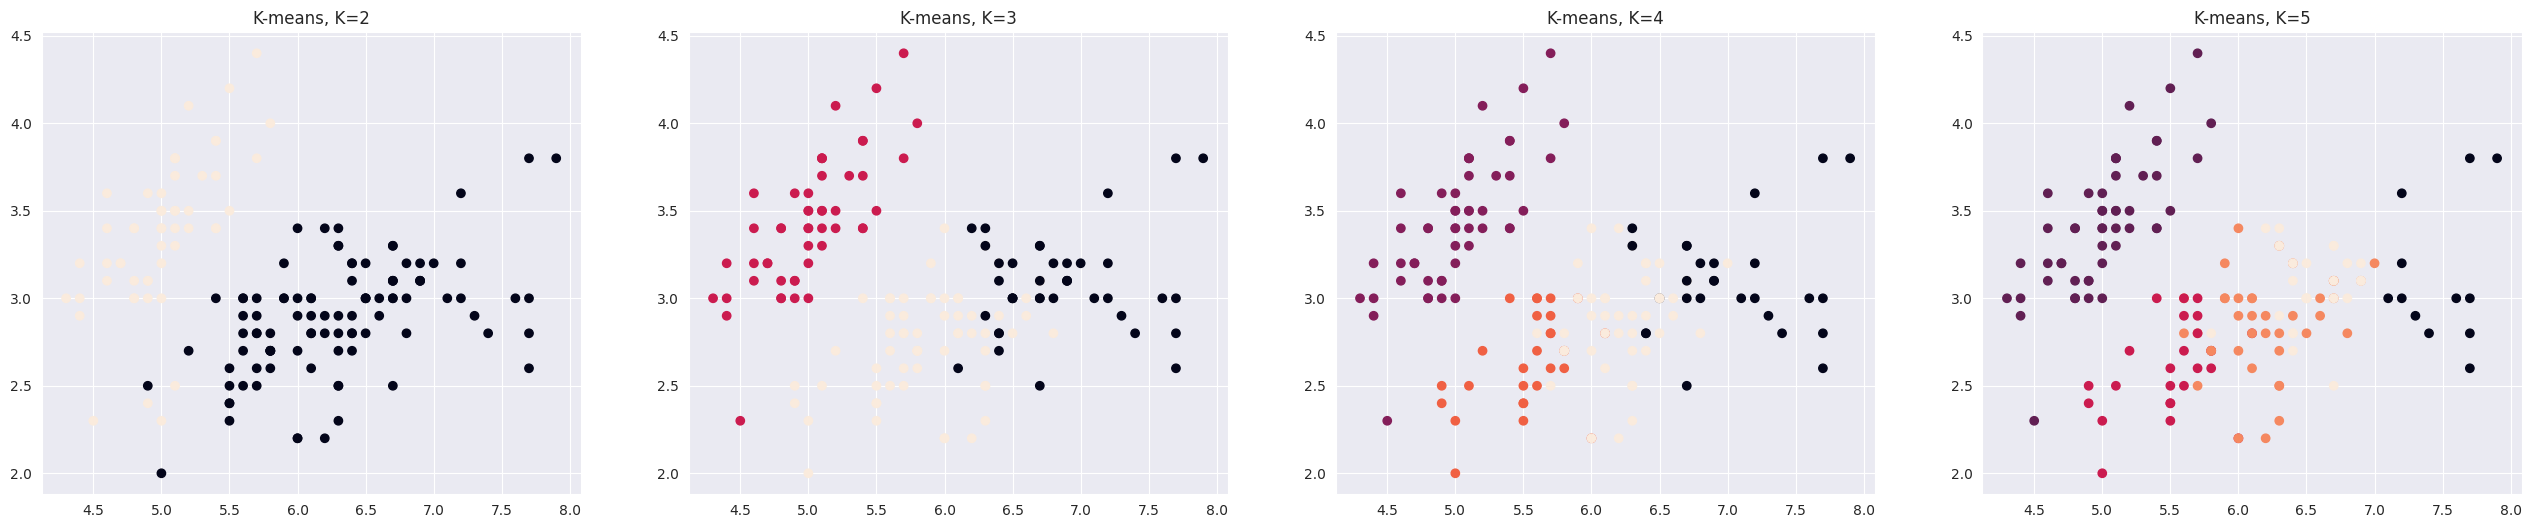

In [30]:
# Parameters that can be changed
Ks = [2, 3, 4, 5]

plot_clusters(Ks, feat_X = X, seed=seed)

Try to play with the code above and answer the following questions:

- Do you see any problems with the code above? How could we make visualization of the clusters clearer/better?
- What happens when you change the parameters (`cluster_sizes` and `n_init`)? How does it affect the plots?

Now, for this problem we know in advance that there should be three different classes of Irises so we know what *K* makes the most sense. But what would you do if you did not have any labels for the data? In this toy dataset we could visualize the clustering of different numbers of clusters in a 2D plot and decide that, perhaps, 2-4 clusters would make sense. That is rarely the case in real life examples, in which case we would have to rely on something else. For K-means you can use the Elbow method to find a good estimate for the number of clusters. Here we use the Elbow method implemented in [Yellowbrick](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) to evaluate the K-means number of clusters. Note that there are a few deprecation warnings outputted here due to future code-updates.

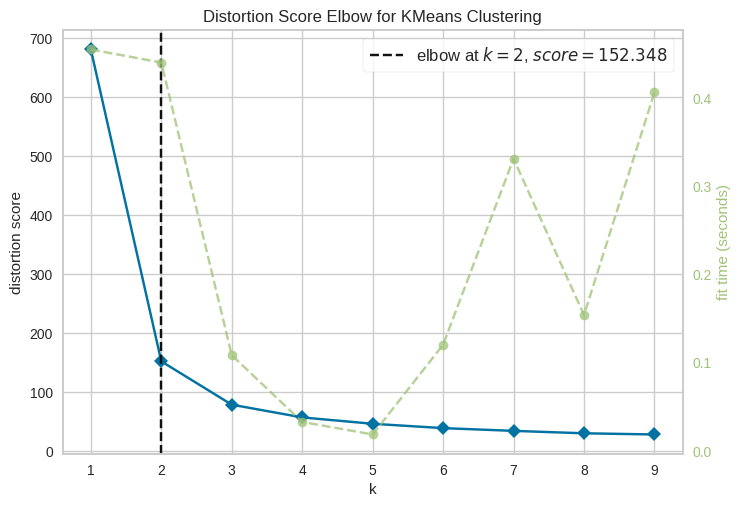

In [31]:
warnings.simplefilter("ignore") # Ignore warnings

from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

# Yellowbrick updates the default matplotlib color schemes, this code will reset it after the cell is run
from yellowbrick.style.rcmod import reset_orig 
reset_orig()

warnings.resetwarnings()

But you can see that even with this method, it is not clear what the best number of clusters is. It looks from the plot that the elbow is at  K=2, but we know that we in fact have three classes. That is why K-means clustering is always a little problematic in real life applications, but it can still be very useful in many cases.

With `yellowbrick` we can also visualize the inter-cluster distance for different values of K. This can be useful to see how the clusters are distributed and how the centroids are placed, which can help us identify optimal K as well. Compare the results of the code below for different values of K:

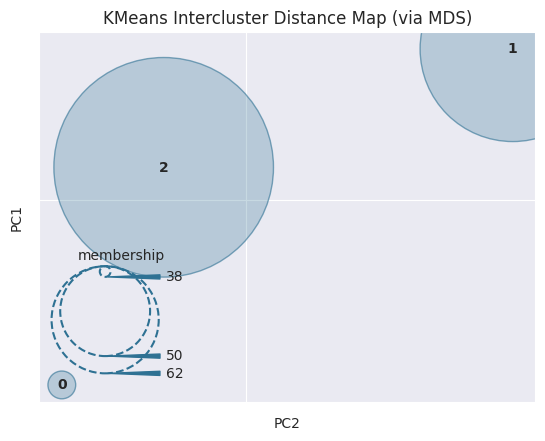

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [32]:
warnings.simplefilter("ignore") # Ignore warnings

from yellowbrick.cluster import InterclusterDistance

model = KMeans(3)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### K-means - concluding remarks

K-means is a fast method for clustering, but requires the user-defined parameter **K**. If you do not have any prior knowledge about the number of expected clusters, it is a good idea to try different values for K and evaluate the clustering, using e.g. the Elbow plot. Another important thing to keep in mind is that the centroids are usually distributed randomly, which influences the clustering result. It is thus normal to re-run the clustering multiple times (handled by the `n_init` parameter of the KMeans-function) with different initial centroids.